In [1]:
import pandas as pd
import numpy as np

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
from xgboost import plot_importance
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

import utils

plt.style.use('ggplot')
%matplotlib inline
from sklearn.metrics import log_loss

In [2]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train)
test = utils.clean_data(test)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

In [3]:
ccc = ['age', 'age_group', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'BMI', 'MAP']
def new_cols(data):    
    for col1 in ccc:
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
        for col2 in ccc:
            data['%s_mul_%s' % (col1, col2)] = data[col1] * data[col2]
            data['%s_mul_log_%s' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
            data['%s_div_log_%s' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 1)

            if col2 == col1:
                continue

            data['%s_div_%s' % (col1, col2)] = data[col1] / (data[col2] + 1)

In [4]:
X_train = X_train.drop(['smoke', 'alco', 'active'], axis=1)
X_train['ap_hi_2'] = X_train['ap_hi'] // 10
X_train['ap_lo_2'] = X_train['ap_lo'] // 10
new_cols(X_train)
X_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke_fair',
       ...
       'MAP_mul_log_gluc', 'MAP_div_log_gluc', 'MAP_div_gluc', 'MAP_mul_BMI',
       'MAP_mul_log_BMI', 'MAP_div_log_BMI', 'MAP_div_BMI', 'MAP_mul_MAP',
       'MAP_mul_log_MAP', 'MAP_div_log_MAP'],
      dtype='object', length=434)

In [27]:
start_columns = [
# "age_group",
# "gender",
# "height",
# "weight",
# "ap_hi",
# "ap_lo",
# "cholesterol",
# "gluc",
# "smoke_restored",
# "alco_restored",
# "active_restored",
#     "MAP",
#     "BMI"
    
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
# "gluc",
"active_fair",
"smoke_restored",
"alco_restored",
# "active_restored",
"height_mul_log_gluc",
"BMI",
"age_group",
# "cholesterol_div_log_age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
# "age_group_mul_log_ap_lo",
]


start=[]
for sc in start_columns:
    start.append(X_train.columns.get_loc(sc))
start

[2, 3, 4, 5, 6, 7, 11, 12, 13, 143, 16, 23, 304, 316]

In [28]:
len(X_train.columns)

434

0.0117925		gender
0.0159198		alco_restored
0.0176887		smoke_restored
0.0412736		active_fair
0.0418632		cholesterol
0.0518868		cholesterol_div_log_gluc
0.0536557		ap_lo
0.0660377		height
0.0807783		height_mul_log_gluc
0.084316		age_group
0.104953		ap_hi
0.106132		weight
0.159788		gluc_mul_log_age
0.163915		BMI


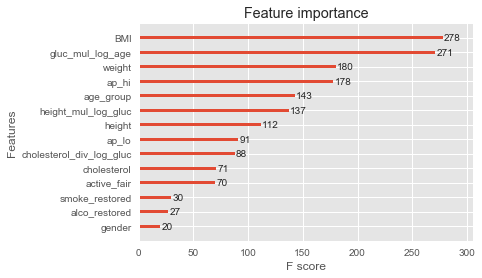

In [29]:
params = {
 'colsample_bytree': 0.875,
 'gamma': 0.05,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 61,

 'reg_alpha': 0,
 'reg_lambda': 10,
 'subsample': 0.7,
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train[start_columns], y_train)
for a, b in sorted(zip(clf.feature_importances_, X_train[start_columns].columns)):
    print(a,b, sep='\t\t')
plot_importance(clf)
plt.show()

In [30]:
kf = StratifiedKFold(random_state=11111, n_splits=10, shuffle=True)
sfs = SFS(clf, 
           k_features=42, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_log_loss',
#            scoring='accuracy',
           n_jobs=1,
           cv=kf)

In [ ]:
sfs = sfs.fit(X_train.values, y_train, start_features=start)

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([-0.52, -0.55])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
sfs.get_metric_dict()

In [13]:
for i in (2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 143, 16, 304, 23, 316):
    print(X_train.columns[i])

gender
height
weight
ap_hi
ap_lo
cholesterol
gluc
active_fair
smoke_restored
alco_restored
active_restored
height_mul_log_gluc
BMI
cholesterol_div_log_gluc
age_group
gluc_mul_log_age


In [ ]:
X_train['lo_14s'].value_counts()